In [1]:
# auto-load when code changes outside
%load_ext autoreload
%autoreload 2
%load_ext pyinstrument
# Load the TensorBoard notebook extension
%load_ext tensorboard

import sys
sys.path.insert(0,'..')

# https://www.kaggle.com/code/jainamshah17/pytorch-starter-image-classification

from GPUtil import showUtilization as gpu_usage
gpu_usage()                             


| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |


In [2]:
import os
import time
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler

import torchvision.transforms as T
import torchvision.models as models
from torchvision.utils import make_grid
from torch.utils.data import RandomSampler

from matplotlib import pyplot as plt

from src.caption import Caption
from src.baseline.coa_model import save_model, load_model, train_validate_test_split
from src.baseline.data_loader import get_mean, get_std


import torch
import gc
# from GPUtil import showUtilization as gpu_usage


## shared code

In [3]:
# essential functions 
def creat_caption_file(filename,columns='image,labels,psum,psum_sq'):
    f = open(filename, "w+")
    f.write(columns)
    f.write('\n')
    f.close()

def write_line_to_file(filename, line):
    with open(filename, 'a') as f:
        f.write(line)
        f.write('\n')
    f.close()

In [4]:
# extract the main info from the label into three columns 

def write_break_down_columns(old_caption_file, new_caption_file):
    with open(old_caption_file, 'r') as f:
        for line in f:
            # skip title
            if 'image,caption,psum,psum_sq' in line:
                continue

            image_name, text_label,psum,psum_sq = line.split(',')
            text_label = text_label.strip()

            struc_label = Caption(text_label, support_plural=True).get_structured()
            shield_color = struc_label['shield']['color']
            first_object = struc_label['objects'][0]
            mod =  first_object['modifiers'][0] if len( first_object['modifiers']) > 0 else ""
            write_line_to_file(new_caption_file, f"{image_name},{first_object['charge']},{mod},{first_object['color']},{shield_color},{psum},{psum_sq}")


In [5]:
# write back the class number to the annotiation file
def get_image_class(item, classes_map):
    for k,v in classes_map.items():
        if v == item:
            return k
    return None
    
def write_class_colum(df, with_class_caption_file, classes_map):
    for _,line in df.iterrows():
        image_name,charge,mod,color,shield_color,psum,psum_sq = line['image'],line['charge'],line['mod'],line['color'],line['shield_color'],line['psum'],line['psum_sq']
        image_class = get_image_class((charge, mod, color, shield_color),classes_map)

        write_line_to_file(with_class_caption_file, f"{image_name},{charge},{mod},{color},{shield_color},{psum},{psum_sq},{image_class}")


In [32]:
import os
import torch
import pandas as pd
import torchvision.transforms as T
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from src.baseline.vocabulary import Vocabulary
import torchdatasets as td
from src.utils import print_time
from pathlib import Path


class CoAClassDataset(td.Dataset):

    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5, vocab=None, device="cpu", calc_mean=False):
        super().__init__()  # for the td.Dataset
        self.root_dir = root_dir
        self.transform = transform
        self.device = device
        self.df = pd.read_csv(captions_file)
        self.calc_mean = calc_mean

        # Get image and caption colum from the dataframe
        self.img_names = self.df["image"]
        self.classes = self.df["class"]

        # Get pixels colum from the dataframe
        try:
            self.psum = self.df["psum"]
        except IndexError:
            print('no pixels sum column')

        try:
            self.psum_sq = self.df["psum_sq"]
        except IndexError:
            print('no squared pixels sum column')


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        """Read the image and return needed information to 
        be used later by the loader

        Args:
           idx(int): index of the image we want to read in the list

        Returns:
            tensor: image tensor 
            string: image class
            float: sum of the pixels -> to calculate the mean 
            float: squared sum of the pixels -> to calculate the std
            string: image file name 
        """
        if self.calc_mean == True:
            return torch.tensor([]), torch.tensor([]), float(self.psum[idx]), float(self.psum_sq[idx]), self.img_names[idx]
        else:
            try:
                return self._get_image_tensor(idx), self._get_label_class(idx), float(self.psum[idx]), float(self.psum_sq[idx]), self.img_names[idx]
            except TypeError or IndexError:
                print(f' Error, cannot find image with index: {str(idx)}')

    def _get_image_tensor(self, idx):
        img_name = self.img_names[idx]

        img_location = os.path.join(self.root_dir, img_name)

        my_image = Path(img_location)
        if not my_image.exists():
            print(f'skipping image {img_name}, as it does not exist')

        img = Image.open(img_location).convert("RGB")
#         print(img)
        # apply the transfromation to the image
        if self.transform is not None:
#             print('self.transform is not None')
            img_t = self.transform(img)
        else:
            trans = T.ToTensor()
            img_t = trans(img)
#         print('img_t: ',img_t)

        return img_t

    def _get_label_class(self, idx):
        
        label_class = self.classes[idx]
#         if self.transform is not None:
#             label_class_t = self.transform(label_class)
#         else:
#             trans = T.ToTensor()
#             label_class_t = trans(label_class)

        return label_class

    



In [7]:
def visualize_one_batch(data_loader):
    # Visualize one training batch
    for images,classes,_,_,_ in data_loader:
        print(type(classes))
        fig, ax = plt.subplots(figsize = (25, 25))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, 5).permute(1,2,0))
        break


In [33]:
def calc_accuracy(true,pred):
    pred = F.softmax(pred, dim = 1)
    true = torch.zeros(pred.shape[0], pred.shape[1]).scatter_(1, true.unsqueeze(1), 1.)
    acc = (true.argmax(-1) == pred.argmax(-1)).float().detach().numpy()
    acc = float((100 * acc.sum()) / len(acc))
    return round(acc, 4)


In [34]:
### Training Code
from src.pytorchtools import EarlyStopping, EarlyStoppingAccuracy

def train_classification_model(model, optimizer, criterion, lr_scheduler, epochs, train_data_loader, val_data_loader, device):
    from tqdm import tqdm
    
    # initialize the early_stopping object
    checkpoint_file=f"{data_location}/classification-checkpoint.pt"
    early_stopping = EarlyStoppingAccuracy(patience=10, verbose=True, path=checkpoint_file)

    for epoch in range(epochs):
        start = time.time()

        #Epoch Loss & Accuracy
        train_epoch_loss = []
        train_epoch_accuracy = []
        _iter = 1

        #Val Loss & Accuracy
        val_epoch_loss = []
        val_epoch_accuracy = []

        # Training
        with tqdm(train_data_loader, unit="batch") as tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))
            for images, labels,_,_,_ in tepoch: 
                images = images.to(device)
                labels = labels.to(device)

                #Reset Grads
                optimizer.zero_grad()

                #Forward ->
                preds = model(images)

                #Calculate Accuracy
                acc = calc_accuracy(labels.cpu(), preds.cpu())

                #Calculate Loss & Backward, Update Weights (Step)
                loss = criterion(preds, labels)
                loss.backward()
                optimizer.step()
#                 lr_scheduler.step()
                
                #Append loss & acc
                loss_value = loss.item()
                train_epoch_loss.append(loss_value)
                train_epoch_accuracy.append(acc)

                tepoch.set_postfix({'train_epoch_loss': loss_value})
    #             tepoch.set_postfix({'train_epoch_accuracy',acc})

                if _iter % 500 == 0:
                    print("> Iteration {} < ".format(_iter))
                    print("Iter Loss = {}".format(round(loss_value, 4)))
                    print("Iter Accuracy = {} % \n".format(acc))

                _iter += 1

        # tryinf to free the memory
#         gc.collect()
#         torch.cuda.empty_cache()
#         gpu_usage()                             

        #Validation
        with tqdm(val_data_loader, unit="batch") as tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            for images, labels,_,_,_ in tepoch:
                images = images.to(device)
                labels = labels.to(device)

                #Forward ->
                preds = model(images)

                #Calculate Accuracy
                acc = calc_accuracy(labels.cpu(), preds.cpu())

                #Calculate Loss
                loss = criterion(preds, labels)

                #Append loss & acc
                loss_value = loss.item()
                val_epoch_loss.append(loss_value)
                val_epoch_accuracy.append(acc)
                tepoch.set_postfix({'val_epoch_loss': loss_value})
    #             tepoch.set_postfix({'val_epoch_accuracy',acc})


        train_epoch_loss = np.mean(train_epoch_loss)
        train_epoch_accuracy = np.mean(train_epoch_accuracy)

        val_epoch_loss = np.mean(val_epoch_loss)
        val_epoch_accuracy = np.mean(val_epoch_accuracy)

        end = time.time()

        train_loss.append(train_epoch_loss)
        train_accuracy.append(train_epoch_accuracy)

        val_loss.append(val_epoch_loss)
        val_accuracy.append(val_epoch_accuracy)

        #Print Epoch Statistics
        print("** Epoch {} ** - Epoch Time {}".format(epoch, int(end-start)))
        print("Train Loss = {}".format(round(train_epoch_loss, 4)))
        print("Train Accuracy = {} % \n".format(train_epoch_accuracy))
        print("Val Loss = {}".format(round(val_epoch_loss, 4)))
        print("Val Accuracy = {} % \n".format(val_epoch_accuracy))
        
        early_stopping(val_epoch_accuracy, model, optimizer, epoch)
           
        if early_stopping.early_stop:
            print("Early stopping. Stopping the training of the model.")
            break

    return model, train_epoch_loss, train_epoch_accuracy, val_epoch_loss, val_epoch_accuracy




In [35]:
def test_classification_model(model, test_data_loader):
    test_epoch_loss = []
    test_epoch_accuracy = []

    test_loss = []
    test_accuracy = []

    # model.eval()
    with torch.no_grad():
        for images, labels,_,_,_ in test_data_loader:
            print(type(labels))
            images = images.to("cpu")
            labels = labels.to("cpu")

            #Forward ->
            preds = model(images)

            #Calculate Accuracy
            acc = calc_accuracy(labels.cpu(), preds.cpu())

            #Calculate Loss
            loss = criterion(preds, labels)

            #Append loss & acc
            loss_value = loss.item()
            test_epoch_loss.append(loss_value)
            test_epoch_accuracy.append(acc)

    test_epoch_loss = np.mean(test_epoch_loss)
    test_epoch_accuracy = np.mean(test_epoch_accuracy)

    test_loss.append(test_epoch_loss)
    test_accuracy.append(test_epoch_accuracy)

    print("Test Loss = {}".format(round(test_epoch_loss, 4)))
    print("Test Accuracy = {} % \n".format(test_epoch_accuracy))



# Train on dataset with single object

## Data preprocessing 

In [11]:

MISSING_TOKEN = 'None'

In [36]:
# data_location =  '../baseline-gen-data/small/'
data_location =  '/home/salnabulsi/coat-of-arms/data/new/'
caption_file = data_location + 'test_real_captions_psumsq.txt'
new_caption_file = data_location + '/new-labels-psumsq-2.txt'




In [47]:
creat_caption_file(new_caption_file, 'image,charge,mod,color,shield_color,psum,psum_sq')


In [48]:
write_break_down_columns(caption_file, new_caption_file)

ValueError (not raised): label "O S eagle per fess" cannot be parsed. The chunk "per" cannot be fit into any category.
ValueError (not raised): label "O S lion naissant" cannot be parsed. The chunk "naissant" cannot be fit into any category.
ValueError (not raised): label "O S lion naissant" cannot be parsed. The chunk "naissant" cannot be fit into any category.
ValueError (not raised): label "A S cross tau retracted" cannot be parsed. The chunk "tau" cannot be fit into any category.
ValueError (not raised): label "A S cross tau retracted" cannot be parsed. The chunk "retracted" cannot be fit into any category.
ValueError (not raised): label "B A cross formy fitchy" cannot be parsed. The chunk "formy" cannot be fit into any category.
ValueError (not raised): label "B A cross formy fitchy" cannot be parsed. The chunk "fitchy" cannot be fit into any category.


In [13]:

df = pd.read_csv(new_caption_file).fillna(MISSING_TOKEN)
df

image charge           mod color shield_color  \
0                  6423_G A cross.jpg  cross          None     A            G   
1          1739_A G cross patonce.jpg  cross       patonce     G            A   
2           2870_O S lion rampant.jpg   lion       rampant     S            O   
3                 18746_S A eagle.jpg  eagle          None     A            S   
4                  4660_G O eagle.jpg  eagle          None     O            G   
..                                ...    ...           ...   ...          ...   
145                6679_O S eagle.jpg  eagle          None     S            O   
146  29394_G O eagle doubleheaded.jpg  eagle  doubleheaded     O            G   
147          398_A S lion rampant.jpg   lion       rampant     S            A   
148                4459_B O eagle.jpg  eagle          None     O            B   
149         5302_O B cross moline.jpg  cross        moline     B            O   

              psum        psum_sq  
0    795074.312500  609741.125000  
1    719996.687500  553701.875000  
2    370225.062500  231052.937500  
3    545993.937500  372998.000000  
4     20764.722656   12016.292969  
..             ...            ...  
145  565107.125000  409840.343750  
146  617640.000000  469392.843750  
147  673486.000000  517662.500000  
148  621506.687500  425807.562500  
149  736156.500000  530974.250000  

[150 rows x 7 columns]

In [14]:
# Getting classes
column_values = df[['charge','mod', 'color', 'shield_color']].value_counts(dropna=False)
column_values

charge  mod           color  shield_color
lion    rampant       O      G               9
                      G      A               6
eagle   None          S      O               6
lion    rampant       G      O               6
                      B      O               6
                                            ..
eagle   doubleheaded  A      S               1
        None          G      B               1
cross   moline        B      O               1
eagle   None          G      O               1
lion    passt guard   O      G               1
Length: 63, dtype: int64

In [15]:
classes = list(column_values.to_dict().keys())
classes

[('lion', 'rampant', 'O', 'G'),
 ('lion', 'rampant', 'G', 'A'),
 ('eagle', 'None', 'S', 'O'),
 ('lion', 'rampant', 'G', 'O'),
 ('lion', 'rampant', 'B', 'O'),
 ('lion', 'rampant', 'A', 'B'),
 ('lion', 'rampant', 'S', 'O'),
 ('lion', 'rampant', 'S', 'A'),
 ('eagle', 'None', 'O', 'B'),
 ('cross', 'moline', 'G', 'A'),
 ('eagle', 'doubleheaded', 'S', 'O'),
 ('eagle', 'None', 'O', 'G'),
 ('eagle', 'None', 'A', 'G'),
 ('cross', 'None', 'G', 'O'),
 ('lion', 'rampant', 'A', 'G'),
 ('lion', 'rampant', 'B', 'A'),
 ('lion', 'rampant', 'O', 'B'),
 ('lion', 'rampant', 'O', 'S'),
 ('eagle', 'None', 'G', 'A'),
 ('cross', 'None', 'A', 'B'),
 ('cross', 'None', 'G', 'A'),
 ('cross', 'None', 'S', 'A'),
 ('cross', 'None', 'S', 'O'),
 ('cross', 'moline', 'S', 'O'),
 ('cross', 'None', 'A', 'G'),
 ('cross', 'None', 'A', 'V'),
 ('lion', 'None', 'S', 'O'),
 ('eagle', 'doubleheaded', 'G', 'A'),
 ('eagle', 'doubleheaded', 'A', 'G'),
 ('eagle', 'None', 'S', 'A'),
 ('eagle', 'None', 'O', 'V'),
 ('eagle', 'doublehea

In [16]:
len(classes)

63

In [17]:
type(classes[0])

tuple

In [18]:
# Give unique number to each class, , easier than handeling an enum of three strings!

CLASSES_MAP = {}
for i in range(len(classes)):
    CLASSES_MAP[i] = classes[i]
    
CLASSES_MAP


{0: ('lion', 'rampant', 'O', 'G'),
 1: ('lion', 'rampant', 'G', 'A'),
 2: ('eagle', 'None', 'S', 'O'),
 3: ('lion', 'rampant', 'G', 'O'),
 4: ('lion', 'rampant', 'B', 'O'),
 5: ('lion', 'rampant', 'A', 'B'),
 6: ('lion', 'rampant', 'S', 'O'),
 7: ('lion', 'rampant', 'S', 'A'),
 8: ('eagle', 'None', 'O', 'B'),
 9: ('cross', 'moline', 'G', 'A'),
 10: ('eagle', 'doubleheaded', 'S', 'O'),
 11: ('eagle', 'None', 'O', 'G'),
 12: ('eagle', 'None', 'A', 'G'),
 13: ('cross', 'None', 'G', 'O'),
 14: ('lion', 'rampant', 'A', 'G'),
 15: ('lion', 'rampant', 'B', 'A'),
 16: ('lion', 'rampant', 'O', 'B'),
 17: ('lion', 'rampant', 'O', 'S'),
 18: ('eagle', 'None', 'G', 'A'),
 19: ('cross', 'None', 'A', 'B'),
 20: ('cross', 'None', 'G', 'A'),
 21: ('cross', 'None', 'S', 'A'),
 22: ('cross', 'None', 'S', 'O'),
 23: ('cross', 'moline', 'S', 'O'),
 24: ('cross', 'None', 'A', 'G'),
 25: ('cross', 'None', 'A', 'V'),
 26: ('lion', 'None', 'S', 'O'),
 27: ('eagle', 'doubleheaded', 'G', 'A'),
 28: ('eagle', 'd

In [19]:
classes_to_int = CLASSES_MAP.keys()
classes_to_int

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62])

In [20]:
new_with_class_caption_file = data_location + '/new-labels-class-psumsq-2.txt'


In [73]:
creat_caption_file(new_with_class_caption_file, 'image,charge,mod,color,shield_color,psum,psum_sq,class')


In [74]:
write_class_colum(df, new_with_class_caption_file, CLASSES_MAP)
    

In [21]:
df_new = pd.read_csv(new_with_class_caption_file)
df_new

image charge           mod color shield_color  \
0                  6423_G A cross.jpg  cross          None     A            G   
1          1739_A G cross patonce.jpg  cross       patonce     G            A   
2           2870_O S lion rampant.jpg   lion       rampant     S            O   
3                 18746_S A eagle.jpg  eagle          None     A            S   
4                  4660_G O eagle.jpg  eagle          None     O            G   
..                                ...    ...           ...   ...          ...   
145                6679_O S eagle.jpg  eagle          None     S            O   
146  29394_G O eagle doubleheaded.jpg  eagle  doubleheaded     O            G   
147          398_A S lion rampant.jpg   lion       rampant     S            A   
148                4459_B O eagle.jpg  eagle          None     O            B   
149         5302_O B cross moline.jpg  cross        moline     B            O   

              psum        psum_sq  class  
0    795074.312500  609741.125000     24  
1    719996.687500  553701.875000     36  
2    370225.062500  231052.937500      6  
3    545993.937500  372998.000000     33  
4     20764.722656   12016.292969     11  
..             ...            ...    ...  
145  565107.125000  409840.343750      2  
146  617640.000000  469392.843750     31  
147  673486.000000  517662.500000      7  
148  621506.687500  425807.562500      8  
149  736156.500000  530974.250000     60  

[150 rows x 8 columns]

In [22]:
# train, validate, test = train_validate_test_split(df_new, train_percent=.6, validate_percent=.2, seed=None)

train_annotation_file = data_location + '/train_labels_psumsq-2.txt'
val_annotation_file  = data_location + '/val_labels_psumsq-2.txt'
test_annotation_file  = data_location + '/test_labels_psumsq-2.txt'

# train.to_csv(train_annotation_file, sep=',',index=False)
# test.to_csv(test_annotation_file, sep=',',index=False)
# validate.to_csv(val_annotation_file, sep=',',index=False)


# print("There are {} total images".format(len(df)))

df1 = pd.read_csv(train_annotation_file)
print("There are {} train images".format(len(df1)))

df2 = pd.read_csv(val_annotation_file)
print("There are {} val images".format(len(df2)))

df3 = pd.read_csv(test_annotation_file)
print("There are {} test images".format(len(df3)))
df2

There are 90 train images
There are 30 val images
There are 30 test images


image charge           mod color shield_color  \
0                 2712_G A eagle.jpg  eagle          None     A            G   
1    4150_A G eagle doubleheaded.jpg  eagle  doubleheaded     G            A   
2    6178_A G eagle doubleheaded.jpg  eagle  doubleheaded     G            A   
3          4289_V A lion rampant.jpg   lion       rampant     A            V   
4                  5096_B O lion.jpg   lion          None     O            B   
5          6736_O B lion rampant.jpg   lion       rampant     B            O   
6                23292_O S eagle.jpg  eagle          None     S            O   
7                 3783_A S cross.jpg  cross          None     S            A   
8          3324_O G lion rampant.jpg   lion       rampant     G            O   
9                 6679_O S eagle.jpg  eagle          None     S            O   
10           -1_G O lion rampant.jpg   lion       rampant     O            G   
11               12436_V A cross.jpg  cross          None     A            V   
12               18847_B A eagle.jpg  eagle          None     A            B   
13         6384_A G cross moline.jpg  cross        moline     G            A   
14                6587_G A eagle.jpg  eagle          None     A            G   
15         2870_O S lion rampant.jpg   lion       rampant     S            O   
16                 255_O V cross.jpg  cross          None     V            O   
17  18825_O S eagle doubleheaded.jpg  eagle  doubleheaded     S            O   
18                6150_A G cross.jpg  cross          None     G            A   
19         5302_O B cross moline.jpg  cross        moline     B            O   
20        18863_B A lion rampant.jpg   lion       rampant     A            B   
21   1537_A S eagle doubleheaded.jpg  eagle  doubleheaded     S            A   
22               29733_O G cross.jpg  cross          None     G            O   
23                3551_G A eagle.jpg  eagle          None     A            G   
24               10757_B O eagle.jpg  eagle          None     O            B   
25               29743_O A eagle.jpg  eagle          None     A            O   
26                7037_A G cross.jpg  cross          None     G            A   
27                7788_S A cross.jpg  cross          None     A            S   
28         1154_A G lion rampant.jpg   lion       rampant     G            A   
29         4250_G O lion rampant.jpg   lion       rampant     O            G   

            psum        psum_sq  class  
0   692423.31250  497456.375000     12  
1   682835.50000  511584.562500     27  
2   718230.43750  534577.000000     27  
3   679316.31250  474126.125000     45  
4   684196.62500  495321.062500     51  
5   733393.93750  543630.875000      4  
6   610619.68750  444984.187500      2  
7   639603.56250  477835.500000     21  
8   613816.25000  388984.250000      3  
9   565107.12500  409840.343750      2  
10  641264.56250  434954.625000      0  
11  795739.12500  584367.812500     25  
12  326878.53125  205838.390625     40  
13  799462.31250  622638.937500      9  
14  654807.12500  497219.437500     12  
15  370225.06250  231052.937500      6  
16  754614.06250  557038.875000     47  
17  521933.31250  418242.625000     10  
18  833470.31250  660386.250000     20  
19  736156.50000  530974.250000     60  
20  637955.37500  437030.281250      5  
21  607447.43750  439142.218750     53  
22  610293.87500  505532.625000     13  
23  611035.62500  438499.812500     12  
24  643019.18750  467219.750000      8  
25  637333.12500  543397.437500     44  
26  655017.00000  501396.468750     20  
27  702776.00000  514615.437500     35  
28  803597.75000  610888.125000      1  
29  646820.87500  469041.375000      0

# Dataset and Dataloader  

In [23]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

device

device(type='cuda', index=0)

In [24]:
BATCH_SIZE = 32
NUM_WORKER = 2 #### this needs multi-core
# NUM_WORKER = 0 #### this needs multi-core
pin_memory=False,
calc_mean=False
SHUFFLE=True

# Mean and Std  

In [25]:
images_location = data_location + '/resized'

train_dataset = CoAClassDataset(images_location, 
                     train_annotation_file, 
                     transform=None, 
                     device=device,
                     calc_mean=True)

train_data_loader = DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    sampler = None,
    num_workers = NUM_WORKER,
)


In [26]:

dataiter = iter(train_data_loader)
images,classes,_,_,_ = next(dataiter)
images,classes

(tensor([], size=(32, 0)), tensor([], size=(32, 0)))

In [27]:
mean = get_mean(train_dataset, train_data_loader, 621 , 634)

# mean_file = f'{data_location}/mean.txt'
# with open(mean_file, 'w') as file:
#     file.write(str(float(mean)))



In [28]:
std = get_std(train_dataset, train_data_loader, mean, 621 , 634)

# std_file = f'{data_location}/std.txt'
# with open(std_file, 'w') as file:
#     file.write(str(float(std)))


In [29]:
mean, std

(tensor(0.5162, dtype=torch.float64), tensor(0.3284, dtype=torch.float64))

# Dataset and Dataloader  

In [86]:
transform = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize(mean, std)
])


In [87]:
train_dataset = CoAClassDataset(images_location, 
                     train_annotation_file, 
                     transform=transform, 
                     device=device,
                     calc_mean=False)

val_dataset = CoAClassDataset(images_location, 
                     val_annotation_file, 
                     transform=transform, 
                     device=device,
                     calc_mean=False)

test_dataset = CoAClassDataset(images_location, 
                     test_annotation_file, 
                     transform=transform, 
                     device=device,
                     calc_mean=False)

train_dataset,val_dataset,test_dataset

(__main__.CoAClassDataset(root_dir=/home/salnabulsi/coat-of-arms/data/new//resized, transform=Compose(
     Resize(size=226, interpolation=bilinear, max_size=None, antialias=None)
     RandomCrop(size=(224, 224), padding=None)
     ToTensor()
     Normalize(mean=0.5161571236990756, std=0.32835697916343526)
 ), device=cuda:0, df=                               image charge           mod color shield_color  \
 0          1335_G A lion rampant.jpg   lion       rampant     A            G   
 1   29394_G O eagle doubleheaded.jpg  eagle  doubleheaded     O            G   
 2                 5401_B O eagle.jpg  eagle          None     O            B   
 3           715_O S lion rampant.jpg   lion       rampant     S            O   
 4                 5855_O S cross.jpg  cross          None     S            O   
 ..                               ...    ...           ...   ...          ...   
 85          398_A S lion rampant.jpg   lion       rampant     S            A   
 86        18220_A S li

In [88]:
# Data Loader  -  using Sampler (YT Video)

train_random_sampler = RandomSampler(train_dataset)
val_random_sampler = RandomSampler(val_dataset)
test_random_sampler = RandomSampler(test_dataset)

# --------------------------------------------------

# Shuffle Argument is mutually exclusive with Sampler!
train_data_loader = DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    sampler = train_random_sampler,
    num_workers = NUM_WORKER,
)

val_data_loader = DataLoader(
    dataset = val_dataset,
    batch_size = BATCH_SIZE,
    sampler = val_random_sampler,
    num_workers = NUM_WORKER,
)

test_data_loader = DataLoader(
    dataset = test_dataset,
    batch_size = BATCH_SIZE,
    sampler = test_random_sampler,
    num_workers = NUM_WORKER,
)

<class 'torch.Tensor'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


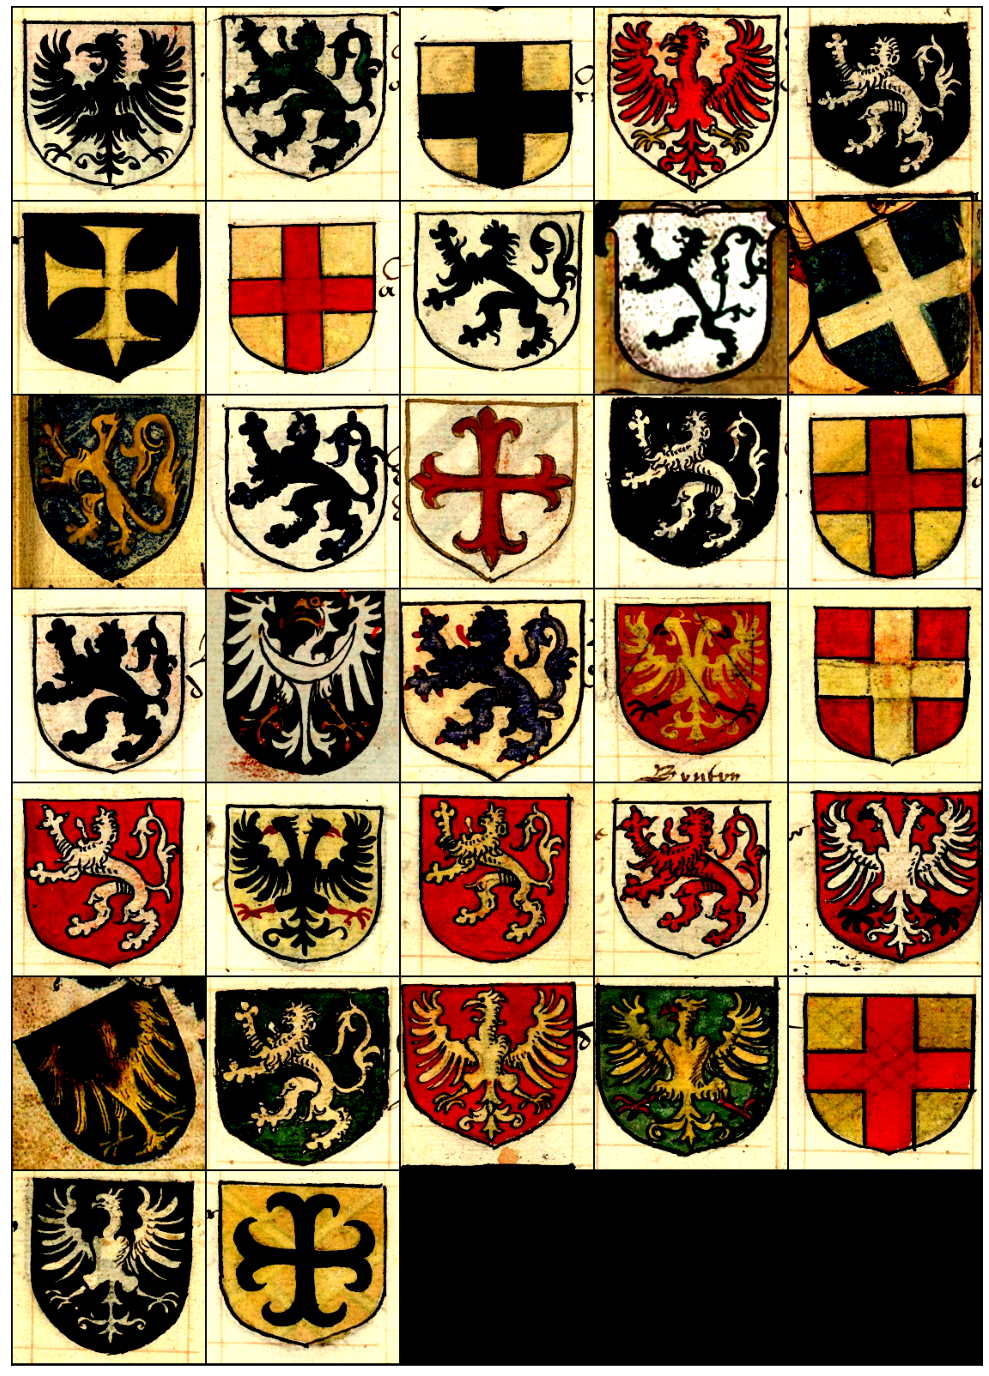

In [89]:


visualize_one_batch(train_data_loader)

Caption: 9961_O G lion rampant.jpg lion rampant G
(604, 614, 3)


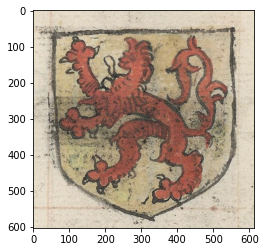

In [90]:
import matplotlib.image as mpimg
i = 8
image_path = images_location +'/'+ df1.iloc[i,0]
print("Caption:", df1.iloc[i,0], df1.iloc[i,1], df.iloc[i,2],df1.iloc[i,3])
img=mpimg.imread(image_path)
print(img.shape)
plt.imshow(img)
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


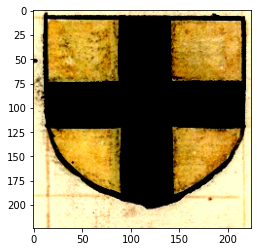

In [91]:
dataiter = iter(train_data_loader)
images,classes,_,_,_ = next(dataiter)
img = images[0]
# print(img)
# img=mpimg.imread(image_path)
print(img.shape)
# plt.imshow(img)
plt.imshow(img.permute(1,2,0))
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>


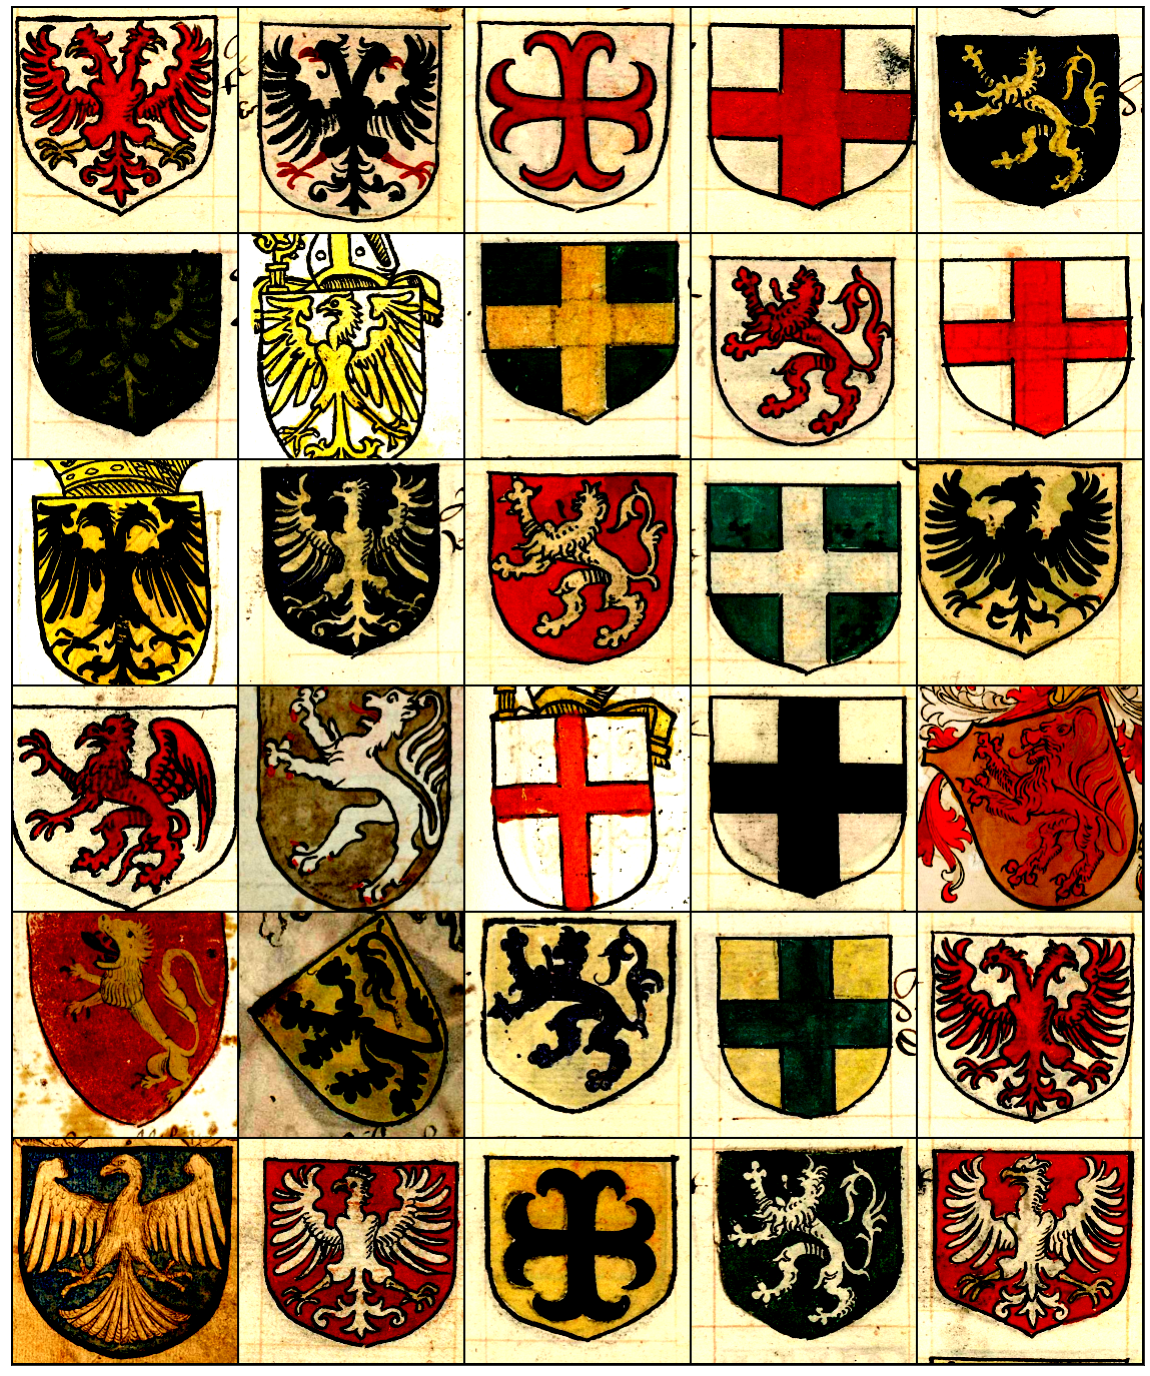

In [95]:
visualize_one_batch(val_data_loader)

# Model Definition

In [96]:
### Define model
model = models.vgg16(pretrained = True)

### Modifying last few layers and no of classes
# NOTE: cross_entropy loss takes unnormalized op (logits), then function itself applies softmax and calculates loss, so no need to include softmax here
model.classifier = nn.Sequential(
    nn.Linear(25088, 4096, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.5),
    nn.Linear(4096, 2048, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.5),
    nn.Linear(2048, 200)
)


In [97]:

# from torchviz import make_dot, make_dot_from_trace

# make_dot(model, params=dict(model.named_parameters()))


# Model Training, Validation and Testing lr = 0.0001

In [98]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

model.to(device)

### Training Details

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.75)
criterion = nn.CrossEntropyLoss()

train_loss = []
train_accuracy = []

val_loss = []
val_accuracy = []

epochs = 100
CUDA_LAUNCH_BLOCKING=1

In [99]:

model, train_epoch_loss, train_epoch_accuracy, val_epoch_loss, val_epoch_accuracy = train_classification_model(model,optimizer, criterion, lr_scheduler, epochs, train_data_loader, val_data_loader, device)


Epoch 0:   0%|                                            | 0/3 [00:00<?, ?batch/s]

Epoch-0 lr: 0.0001


/home/salnabulsi/.thesis-py38/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Epoch 0: 100%|███████████████| 1/1 [00:01<00:00,  1.18s/batch, val_epoch_loss=5.18]


** Epoch 0 ** - Epoch Time 3
Train Loss = 5.2576
Train Accuracy = 3.6057666666666663 % 

Val Loss = 5.1797
Val Accuracy = 3.3333 % 

Accuracy increased (0.000000 --> 3.333300).  Saving model ...


Epoch 1:   0%|                                            | 0/3 [00:00<?, ?batch/s]

Epoch-1 lr: 0.0001


Epoch 1: 100%|████████████████| 1/1 [00:01<00:00,  1.23s/batch, val_epoch_loss=5.6]


** Epoch 1 ** - Epoch Time 2
Train Loss = 4.3837
Train Accuracy = 16.586533333333332 % 

Val Loss = 5.604
Val Accuracy = 3.3333 % 

Accuracy increased (3.333300 --> 3.333300).  Saving model ...


Epoch 2:   0%|                                            | 0/3 [00:00<?, ?batch/s]

Epoch-2 lr: 0.0001


Epoch 2: 100%|███████████████| 1/1 [00:01<00:00,  1.25s/batch, val_epoch_loss=5.68]


** Epoch 2 ** - Epoch Time 2
Train Loss = 2.9935
Train Accuracy = 27.483966666666664 % 

Val Loss = 5.6757
Val Accuracy = 6.6667 % 

Accuracy increased (3.333300 --> 6.666700).  Saving model ...


Epoch 3:   0%|                                            | 0/3 [00:00<?, ?batch/s]

Epoch-3 lr: 0.0001


Epoch 3: 100%|███████████████| 1/1 [00:01<00:00,  1.20s/batch, val_epoch_loss=7.21]


** Epoch 3 ** - Epoch Time 2
Train Loss = 2.0399
Train Accuracy = 48.958333333333336 % 

Val Loss = 7.2139
Val Accuracy = 6.6667 % 

Accuracy increased (6.666700 --> 6.666700).  Saving model ...


Epoch 4:   0%|                                            | 0/3 [00:00<?, ?batch/s]

Epoch-4 lr: 0.0001


Epoch 4: 100%|███████████████| 1/1 [00:01<00:00,  1.26s/batch, val_epoch_loss=6.33]


** Epoch 4 ** - Epoch Time 2
Train Loss = 1.2486
Train Accuracy = 72.51603333333334 % 

Val Loss = 6.3253
Val Accuracy = 6.6667 % 

Accuracy increased (6.666700 --> 6.666700).  Saving model ...


Epoch 5:   0%|                                            | 0/3 [00:00<?, ?batch/s]

Epoch-5 lr: 0.0001


Epoch 5: 100%|███████████████| 1/1 [00:01<00:00,  1.06s/batch, val_epoch_loss=8.13]


** Epoch 5 ** - Epoch Time 2
Train Loss = 0.5715
Train Accuracy = 84.21473333333334 % 

Val Loss = 8.1308
Val Accuracy = 10.0 % 

Accuracy increased (6.666700 --> 10.000000).  Saving model ...


Epoch 6:   0%|                                            | 0/3 [00:00<?, ?batch/s]

Epoch-6 lr: 0.0001


Epoch 6: 100%|███████████████| 1/1 [00:01<00:00,  1.26s/batch, val_epoch_loss=11.5]


** Epoch 6 ** - Epoch Time 2
Train Loss = 0.2556
Train Accuracy = 94.3109 % 

Val Loss = 11.5055
Val Accuracy = 10.0 % 

Accuracy increased (10.000000 --> 10.000000).  Saving model ...


Epoch 7:   0%|                                            | 0/3 [00:00<?, ?batch/s]

Epoch-7 lr: 0.0001


Epoch 7: 100%|████████████████| 1/1 [00:01<00:00,  1.27s/batch, val_epoch_loss=9.5]


** Epoch 7 ** - Epoch Time 2
Train Loss = 0.407
Train Accuracy = 89.10256666666668 % 

Val Loss = 9.5012
Val Accuracy = 23.3333 % 

Accuracy increased (10.000000 --> 23.333300).  Saving model ...


Epoch 8:   0%|                                            | 0/3 [00:00<?, ?batch/s]

Epoch-8 lr: 0.0001


Epoch 8: 100%|███████████████| 1/1 [00:01<00:00,  1.24s/batch, val_epoch_loss=8.34]


** Epoch 8 ** - Epoch Time 2
Train Loss = 0.264
Train Accuracy = 92.22756666666668 % 

Val Loss = 8.3367
Val Accuracy = 6.6667 % 

EarlyStopping counter: 1 out of 10


Epoch 9:   0%|                                            | 0/3 [00:00<?, ?batch/s]

Epoch-9 lr: 0.0001


Epoch 9: 100%|███████████████| 1/1 [00:01<00:00,  1.18s/batch, val_epoch_loss=7.83]


** Epoch 9 ** - Epoch Time 2
Train Loss = 0.1802
Train Accuracy = 92.22756666666668 % 

Val Loss = 7.8299
Val Accuracy = 13.3333 % 

EarlyStopping counter: 2 out of 10


Epoch 10:   0%|                                           | 0/3 [00:00<?, ?batch/s]

Epoch-10 lr: 0.0001


Epoch 10: 100%|███████████████| 1/1 [00:01<00:00,  1.25s/batch, val_epoch_loss=8.3]


** Epoch 10 ** - Epoch Time 2
Train Loss = 0.1403
Train Accuracy = 95.83333333333333 % 

Val Loss = 8.3036
Val Accuracy = 10.0 % 

EarlyStopping counter: 3 out of 10


Epoch 11:   0%|                                           | 0/3 [00:00<?, ?batch/s]

Epoch-11 lr: 0.0001


Epoch 11: 100%|██████████████| 1/1 [00:01<00:00,  1.26s/batch, val_epoch_loss=9.62]


** Epoch 11 ** - Epoch Time 2
Train Loss = 0.0872
Train Accuracy = 97.91666666666667 % 

Val Loss = 9.6213
Val Accuracy = 10.0 % 

EarlyStopping counter: 4 out of 10


Epoch 12:   0%|                                           | 0/3 [00:00<?, ?batch/s]

Epoch-12 lr: 0.0001


Epoch 12: 100%|██████████████| 1/1 [00:01<00:00,  1.27s/batch, val_epoch_loss=9.88]


** Epoch 12 ** - Epoch Time 2
Train Loss = 0.0694
Train Accuracy = 96.875 % 

Val Loss = 9.875
Val Accuracy = 16.6667 % 

EarlyStopping counter: 5 out of 10


Epoch 13:   0%|                                           | 0/3 [00:00<?, ?batch/s]

Epoch-13 lr: 0.0001


Epoch 13: 100%|██████████████| 1/1 [00:01<00:00,  1.24s/batch, val_epoch_loss=10.3]


** Epoch 13 ** - Epoch Time 2
Train Loss = 0.1122
Train Accuracy = 96.875 % 

Val Loss = 10.2898
Val Accuracy = 10.0 % 

EarlyStopping counter: 6 out of 10


Epoch 14:   0%|                                           | 0/3 [00:00<?, ?batch/s]

Epoch-14 lr: 0.0001


Epoch 14: 100%|██████████████| 1/1 [00:01<00:00,  1.25s/batch, val_epoch_loss=10.7]


** Epoch 14 ** - Epoch Time 2
Train Loss = 0.0097
Train Accuracy = 100.0 % 

Val Loss = 10.6839
Val Accuracy = 6.6667 % 

EarlyStopping counter: 7 out of 10


Epoch 15:   0%|                                           | 0/3 [00:00<?, ?batch/s]

Epoch-15 lr: 0.0001


Epoch 15: 100%|██████████████| 1/1 [00:01<00:00,  1.26s/batch, val_epoch_loss=10.7]


** Epoch 15 ** - Epoch Time 2
Train Loss = 0.0202
Train Accuracy = 100.0 % 

Val Loss = 10.7381
Val Accuracy = 10.0 % 

EarlyStopping counter: 8 out of 10


Epoch 16:   0%|                                           | 0/3 [00:00<?, ?batch/s]

Epoch-16 lr: 0.0001


Epoch 16: 100%|██████████████| 1/1 [00:01<00:00,  1.26s/batch, val_epoch_loss=11.8]


** Epoch 16 ** - Epoch Time 2
Train Loss = 0.0151
Train Accuracy = 100.0 % 

Val Loss = 11.7948
Val Accuracy = 3.3333 % 

EarlyStopping counter: 9 out of 10


Epoch 17:   0%|                                           | 0/3 [00:00<?, ?batch/s]

Epoch-17 lr: 0.0001


Epoch 17: 100%|██████████████| 1/1 [00:01<00:00,  1.24s/batch, val_epoch_loss=11.8]

** Epoch 17 ** - Epoch Time 2
Train Loss = 0.0132
Train Accuracy = 98.95833333333333 % 

Val Loss = 11.7543
Val Accuracy = 10.0 % 

EarlyStopping counter: 10 out of 10
Early stopping. Stopping the training of the model.


## Save model to disk

In [100]:

from datetime import datetime

# save the latest model
now = datetime.now() # current date and time
timestr = now.strftime("%m-%d-%Y-%H:%M:%S")
model_full_path = f"{data_location}/classification-model-trained-on-only-real-{timestr}.pth"

model.cpu()
model_state = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_epoch_loss,
    'accuracy': train_epoch_accuracy
}

torch.save(model_state, model_full_path)


In [101]:
model_full_path

'/home/salnabulsi/coat-of-arms/data/new//classification-model-trained-on-only-real-05-04-2023-21:36:13.pth'

In [102]:
model.cuda()


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Test model on synthetic data


In [103]:
# load model from disk 
### creat a new model model
model = models.vgg16(pretrained = True)

### Modifying last few layers and no of classes
model.classifier = nn.Sequential(
    nn.Linear(25088, 4096, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.5),
    nn.Linear(4096, 2048, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.5),
    nn.Linear(2048, 200)
)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0009)


model_file_path =  data_location + '/classification-model-trained-on-only-real-05-18-2023-23:03:08.pth'

saved_model = torch.load(model_file_path, map_location=torch.device(device))

model.load_state_dict(saved_model['model_state_dict'])
optimizer.load_state_dict(saved_model['optimizer_state_dict'])
criterion = nn.CrossEntropyLoss()

loss = saved_model['loss']
accuracy = saved_model['accuracy']

model, optimizer, loss, accuracy

(VGG(
   (features): Sequential(
     (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU(inplace=True)
     (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU(inplace=True)
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (6): ReLU(inplace=True)
     (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (8): ReLU(inplace=True)
     (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (11): ReLU(inplace=True)
     (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (13): ReLU(inplace=True)
     (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (15): ReLU(inplace=True)
     (16): MaxPool2d(kernel_size=2, stride=2, pa

In [104]:
#this cell execution from real classification-model-trained-on-only-real-02-26-2023-13:04:13.pth
test_classification_model(model, test_data_loader)

<class 'torch.Tensor'>
Test Loss = 10.1021
Test Accuracy = 26.6667 % 



In [105]:
import torch
import random
seed = 1234
random.seed(seed)     # python random generator
np.random.seed(seed)  # numpy random generator

torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


test_classification_model(model, test_data_loader)

<class 'torch.Tensor'>
Test Loss = 9.5366
Test Accuracy = 26.6667 % 



# Model Training, Validation and Testing lr = 0.0009


In [106]:

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

model.to(device)

### Training Details

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0009)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.75)
criterion = nn.CrossEntropyLoss()

train_loss = []
train_accuracy = []

val_loss = []
val_accuracy = []

epochs = 100
CUDA_LAUNCH_BLOCKING=1


model, train_epoch_loss, train_epoch_accuracy, val_epoch_loss, val_epoch_accuracy = train_classification_model(model,optimizer, criterion, lr_scheduler, epochs, train_data_loader, val_data_loader, device)



Epoch 0:   0%|                                            | 0/3 [00:00<?, ?batch/s]

Epoch-0 lr: 0.0009


Epoch 0: 100%|████████████████| 1/1 [00:01<00:00,  1.30s/batch, val_epoch_loss=5.1]


** Epoch 0 ** - Epoch Time 2
Train Loss = 267.58
Train Accuracy = 36.69873333333333 % 

Val Loss = 5.0985
Val Accuracy = 0.0 % 

Accuracy increased (0.000000 --> 0.000000).  Saving model ...


Epoch 1:   0%|                                            | 0/3 [00:00<?, ?batch/s]

Epoch-1 lr: 0.0009


Epoch 1: 100%|███████████████| 1/1 [00:01<00:00,  1.29s/batch, val_epoch_loss=5.29]


** Epoch 1 ** - Epoch Time 2
Train Loss = 5.4524
Train Accuracy = 2.0833333333333335 % 

Val Loss = 5.288
Val Accuracy = 3.3333 % 

Accuracy increased (0.000000 --> 3.333300).  Saving model ...


Epoch 2:   0%|                                            | 0/3 [00:00<?, ?batch/s]

Epoch-2 lr: 0.0009


Epoch 2: 100%|███████████████| 1/1 [00:01<00:00,  1.30s/batch, val_epoch_loss=5.28]


** Epoch 2 ** - Epoch Time 2
Train Loss = 30.8394
Train Accuracy = 4.647433333333333 % 

Val Loss = 5.2762
Val Accuracy = 0.0 % 

EarlyStopping counter: 1 out of 10


Epoch 3:   0%|                                            | 0/3 [00:00<?, ?batch/s]

Epoch-3 lr: 0.0009


Epoch 3: 100%|███████████████| 1/1 [00:01<00:00,  1.29s/batch, val_epoch_loss=5.26]


** Epoch 3 ** - Epoch Time 2
Train Loss = 5.2565
Train Accuracy = 3.125 % 

Val Loss = 5.2594
Val Accuracy = 6.6667 % 

Accuracy increased (3.333300 --> 6.666700).  Saving model ...


Epoch 4:   0%|                                            | 0/3 [00:00<?, ?batch/s]

Epoch-4 lr: 0.0009


Epoch 4: 100%|███████████████| 1/1 [00:01<00:00,  1.23s/batch, val_epoch_loss=17.2]


** Epoch 4 ** - Epoch Time 2
Train Loss = 5.0205
Train Accuracy = 3.3653999999999997 % 

Val Loss = 17.2135
Val Accuracy = 3.3333 % 

EarlyStopping counter: 1 out of 10


Epoch 5:   0%|                                            | 0/3 [00:00<?, ?batch/s]

Epoch-5 lr: 0.0009


Epoch 5: 100%|███████████████| 1/1 [00:01<00:00,  1.15s/batch, val_epoch_loss=22.7]


** Epoch 5 ** - Epoch Time 2
Train Loss = 6.2745
Train Accuracy = 3.3653999999999997 % 

Val Loss = 22.7282
Val Accuracy = 3.3333 % 

EarlyStopping counter: 2 out of 10


Epoch 6:   0%|                                            | 0/3 [00:00<?, ?batch/s]

Epoch-6 lr: 0.0009


Epoch 6: 100%|████████████████| 1/1 [00:01<00:00,  1.26s/batch, val_epoch_loss=5.2]


** Epoch 6 ** - Epoch Time 2
Train Loss = 6.4658
Train Accuracy = 4.647433333333333 % 

Val Loss = 5.2041
Val Accuracy = 0.0 % 

EarlyStopping counter: 3 out of 10


Epoch 7:   0%|                                            | 0/3 [00:00<?, ?batch/s]

Epoch-7 lr: 0.0009


Epoch 7: 100%|███████████████| 1/1 [00:01<00:00,  1.34s/batch, val_epoch_loss=5.16]


** Epoch 7 ** - Epoch Time 3
Train Loss = 4.8501
Train Accuracy = 3.6057666666666663 % 

Val Loss = 5.1644
Val Accuracy = 0.0 % 

EarlyStopping counter: 4 out of 10


Epoch 8:   0%|                                            | 0/3 [00:00<?, ?batch/s]

Epoch-8 lr: 0.0009


Epoch 8: 100%|███████████████| 1/1 [00:01<00:00,  1.28s/batch, val_epoch_loss=5.12]


** Epoch 8 ** - Epoch Time 2
Train Loss = 5.0083
Train Accuracy = 5.448733333333333 % 

Val Loss = 5.1233
Val Accuracy = 0.0 % 

EarlyStopping counter: 5 out of 10


Epoch 9:   0%|                                            | 0/3 [00:00<?, ?batch/s]

Epoch-9 lr: 0.0009


Epoch 9: 100%|███████████████| 1/1 [00:01<00:00,  1.28s/batch, val_epoch_loss=8.12]


** Epoch 9 ** - Epoch Time 2
Train Loss = 4.9885
Train Accuracy = 7.532066666666666 % 

Val Loss = 8.12
Val Accuracy = 0.0 % 

EarlyStopping counter: 6 out of 10


Epoch 10:   0%|                                           | 0/3 [00:00<?, ?batch/s]

Epoch-10 lr: 0.0009


Epoch 10: 100%|██████████████| 1/1 [00:01<00:00,  1.20s/batch, val_epoch_loss=7.01]


** Epoch 10 ** - Epoch Time 2
Train Loss = 4.157
Train Accuracy = 1.0416666666666667 % 

Val Loss = 7.0079
Val Accuracy = 0.0 % 

EarlyStopping counter: 7 out of 10


Epoch 11:   0%|                                           | 0/3 [00:00<?, ?batch/s]

Epoch-11 lr: 0.0009


Epoch 11: 100%|██████████████| 1/1 [00:01<00:00,  1.32s/batch, val_epoch_loss=5.06]


** Epoch 11 ** - Epoch Time 3
Train Loss = 4.3552
Train Accuracy = 2.323733333333333 % 

Val Loss = 5.0584
Val Accuracy = 3.3333 % 

EarlyStopping counter: 8 out of 10


Epoch 12:   0%|                                           | 0/3 [00:00<?, ?batch/s]

Epoch-12 lr: 0.0009


Epoch 12: 100%|██████████████| 1/1 [00:01<00:00,  1.26s/batch, val_epoch_loss=7.98]


** Epoch 12 ** - Epoch Time 2
Train Loss = 3.8543
Train Accuracy = 6.730766666666667 % 

Val Loss = 7.981
Val Accuracy = 3.3333 % 

EarlyStopping counter: 9 out of 10


Epoch 13:   0%|                                           | 0/3 [00:00<?, ?batch/s]

Epoch-13 lr: 0.0009


Epoch 13: 100%|██████████████| 1/1 [00:01<00:00,  1.41s/batch, val_epoch_loss=5.48]

** Epoch 13 ** - Epoch Time 3
Train Loss = 3.9779
Train Accuracy = 5.6891 % 

Val Loss = 5.4777
Val Accuracy = 0.0 % 

EarlyStopping counter: 10 out of 10
Early stopping. Stopping the training of the model.


In [107]:

## Save model to disk


from datetime import datetime

# save the latest model
now = datetime.now() # current date and time
timestr = now.strftime("%m-%d-%Y-%H:%M:%S")
model_full_path = f"{data_location}/classification-model-trained-on-only-real-{timestr}.pth"

model.cpu()
model_state = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_epoch_loss,
    'accuracy': train_epoch_accuracy
}

torch.save(model_state, model_full_path)


model_full_path


'/home/salnabulsi/coat-of-arms/data/new//classification-model-trained-on-only-real-05-04-2023-21:38:29.pth'

In [109]:


model.cuda()


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [115]:


## Test model on synthetic data


# load model from disk 
### creat a new model model
model = models.vgg16(pretrained = True)

### Modifying last few layers and no of classes
model.classifier = nn.Sequential(
    nn.Linear(25088, 4096, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.5),
    nn.Linear(4096, 2048, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.5),
    nn.Linear(2048, 200)
)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0009)


model_file_path =  data_location + '/classification-model-trained-on-only-real-05-04-2023-21:38:29.pth'
saved_model = torch.load(model_file_path, map_location=torch.device(device))

model.load_state_dict(saved_model['model_state_dict'])
optimizer.load_state_dict(saved_model['optimizer_state_dict'])
criterion = nn.CrossEntropyLoss()

loss = saved_model['loss']
accuracy = saved_model['accuracy']

model, optimizer, loss, accuracy



(VGG(
   (features): Sequential(
     (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU(inplace=True)
     (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU(inplace=True)
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (6): ReLU(inplace=True)
     (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (8): ReLU(inplace=True)
     (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (11): ReLU(inplace=True)
     (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (13): ReLU(inplace=True)
     (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (15): ReLU(inplace=True)
     (16): MaxPool2d(kernel_size=2, stride=2, pa

In [116]:
test_classification_model(model, test_data_loader)


<class 'torch.Tensor'>
Test Loss = 5.3292
Test Accuracy = 0.0 % 



In [117]:

import torch
import random
seed = 1234
random.seed(seed)     # python random generator
np.random.seed(seed)  # numpy random generator

torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


test_classification_model(model, test_data_loader)


<class 'torch.Tensor'>
Test Loss = 5.2548
Test Accuracy = 3.3333 % 

